In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F
import numpy as np

import timeit
from preprocessing.data_norm import *
from preprocessing.make_idx import *
from preprocessing.make_team import *
from preprocessing.train import *
import re
import copy as cp

In [2]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial
# the default is gpu but if gpu is not available,then use cpu
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
device = torch.device('cpu')
print_every = 100
# show which device to use
print('using device:', device)

using device: cpu


In [3]:
import pandas as pd

In [4]:
teamName = ["Atlanta Hawks","Boston Celtics","Brooklyn Nets","Charlotte Bobcats","Charlotte Hornets",
"Chicago Bulls","Cleveland Cavaliers","Dallas Mavericks","Denver Nuggets","Detroit Pistons",
"Golden State Warriors","Houston Rockets","Indiana Pacers","Los Angeles Clippers","Los Angeles Lakers",
"Memphis Grizzlies","Miami Heat","Milwaukee Bucks","Minnesota Timberwolves","New Jeresy Nets",
"New Orleans Hornets","New Orleans Pelicans","New York Knicks","Oklahoma City Thunder","Orlando Magic",
"Philadelphia 76ers","Phoenix Suns","Portland Trail Blazers","Sacramento Kings","San Antonio Spurs",
"Seattle SuperSonics","Toronto Raptors","Utah Jazz","Vancouver Grizzlies","Washington Bullets","Washington Wizards"]

Abbr = ["ATL","BOS","BKN","CHA","CHA","CHI","CLE","DAL","DEN","DET","GSW","HOU","IND","LAC","LAL","MEM",
"MIA","MIL","MIN","NJN","NOH","NOP","NYK","OKC","ORL","PHI","PHO","POR","SAC","SAS","SEA","TOR",
"UTA","VAN","WSB","WAS"]


In [5]:
'''
when use different idx,we use different features to do training
note:!when saving the model, we should tell which idx used
'''

#index_code1
need_idx = [1,2,3,4,5,6,7,8,9,10,11,12,17,18,19,20]
#need_idx = [2,3,4,5,6,7,8,9,10,11,12,17,18,19]
#need_idx = [1]

In [6]:

# 25 years training, 4 validation, 1 testing
trainYear = 25
startYear_train = 1989
validationYear = 4
startYear_validation = startYear_train + trainYear
testYear = 1
startYear_test = startYear_validation + validationYear
#initialization
player_list_train = [0] * trainYear
winrate_list_train = [0] * trainYear
data_list_train = [0] * trainYear
team_idx_train = [0] * trainYear
data_input_train = [0] * trainYear
loader_train = {}
loader_validation = {}
loader_test = {}
for index in range(trainYear):
    # read the statics and winrate
    playerstats_train = "Player_Data\AvgPlayerStats" + str(index+startYear_train) + ".csv"
    teamstats_train = "Team_data\TeamStats" + str(index+startYear_train) + ".csv"
    # change them into numpy
    player_list_train[index] = pd.read_csv(playerstats_train).values
    winrate_list_train[index] = pd.read_csv(teamstats_train).values
    # we throw away the players name,team ,age and so on
    data_list_train[index] = player_list_train[index][:,4:]
    # do normalization
    data_list_train[index] = data_norm(data_list_train[index])   
    # make a index which is abbr
    team_idx_train[index] = make_idx(winrate_list_train[index],Abbr,teamName)
    # put players in a same team into one matrix
    data_input_train[index] = make_team(player_list_train[index],data_list_train[index],team_idx_train[index],str(index+startYear_train),device,dtype,need_idx)
    # put everyyears' data into one dictionary
    loader_train = dict(loader_train,**data_input_train[index])
    
player_list_validation = [0] * validationYear
winrate_list_validation = [0] * validationYear
data_list_validation = [0] * validationYear
team_idx_validation = [0] * validationYear
data_input_validation = [0] * validationYear
for index in range(validationYear):
    playerstats_validation = "Player_Data\AvgPlayerStats" + str(index+startYear_validation) + ".csv"
    teamstats_validation = "Team_data\TeamStats" + str(index+startYear_validation) + ".csv"
    player_list_validation[index] = pd.read_csv(playerstats_validation).values
    winrate_list_validation[index] = pd.read_csv(teamstats_validation).values
    data_list_validation[index] = player_list_validation[index][:,4:]
    data_list_validation[index] = data_norm(data_list_validation[index])
    team_idx_validation[index] = make_idx(winrate_list_validation[index],Abbr,teamName)
    data_input_validation[index] = make_team(player_list_validation[index],data_list_validation[index],team_idx_validation[index],str(index+startYear_validation),device,dtype,need_idx)
    loader_validation = dict(loader_validation,**data_input_validation[index])

In [7]:


player_list_test = [0] * testYear
winrate_list_test = [0] * testYear
data_list_test = [0] * testYear
team_idx_test = [0] * testYear
data_input_test = [0] * testYear
for index in range(testYear):
    playerstats_test = "Player_Data\AvgPlayerStats" + str(index+startYear_test) + ".csv"
    teamstats_test = "Team_data\TeamStats" + str(index+startYear_test) + ".csv"
    player_list_test[index] = (pd.read_csv(playerstats_test)).values
    winrate_list_test[index] = (pd.read_csv(teamstats_test)).values
    data_list_test[index] = player_list_test[index][:,4:]
    data_list_test[index] = data_norm(data_list_test[index])
    team_idx_test[index] = make_idx(winrate_list_test[index],Abbr,teamName)
    data_input_test[index] = make_team(player_list_test[index],data_list_test[index],team_idx_test[index],str(index+startYear_test),device,dtype,need_idx)
#print(data_input_test[0]['BOS2018'])
#train
#loader_train

In [8]:
model = None
optimizer = None
num_data = 32
# A 4-layer network
# Each layer affine-norm-relu 
layer1 = nn.Sequential(
    nn.Linear(num_data, 1,bias=False),
    #nn.BatchNorm1d(30),
    #nn.ReLU()
)

layer2 = nn.Sequential(
    nn.Linear(30, 60),
    nn.BatchNorm1d(60),
    nn.ReLU()
)

layer3 = nn.Sequential(
    nn.Linear(60, 30),
    nn.BatchNorm1d(30),
    nn.ReLU()
)

layer4 = nn.Sequential(
    nn.Linear(30, 1),
    #nn.BatchNorm1d(1),
    #nn.ReLU()
)
'''
this model is easy to change, when linear or poly, we only use layer one
'''
model = nn.Sequential(
    layer1,
    #layer2,
    #layer3,
    #layer4
)
# learning rate could be changed, advised to be less than 1e-2
learning_rate = 15e-4
# optimizer could be changed, but SGD is ok, weight_decay means add a L2 regulization
optimizer = optim.SGD(model.parameters(), lr=learning_rate,weight_decay = 1e-4)


his_epoch,his_tra,his_val = train(model, loader_train,loader_validation,device,optimizer,dtype,epochs=1000,print_process=False)

E:\Anaconda\envs\cs231n\lib\site-packages\torch\nn\functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


validation_loss:


E:\ece143\preprocessing\train.py:95: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  his_tra.append(loss_perepoch[0].data/25)


tensor(2.1245, grad_fn=<SelectBackward>)
0 tensor(2.0172, grad_fn=<DivBackward0>)
1 tensor(0.5595, grad_fn=<DivBackward0>)
2 tensor(0.3877, grad_fn=<DivBackward0>)
3 tensor(0.3249, grad_fn=<DivBackward0>)
4 tensor(0.2956, grad_fn=<DivBackward0>)
5 tensor(0.2796, grad_fn=<DivBackward0>)
6 tensor(0.2694, grad_fn=<DivBackward0>)
7 tensor(0.2622, grad_fn=<DivBackward0>)
8 tensor(0.2565, grad_fn=<DivBackward0>)
9 tensor(0.2518, grad_fn=<DivBackward0>)
validation_loss:
tensor(0.2844, grad_fn=<SelectBackward>)
10 tensor(0.2477, grad_fn=<DivBackward0>)
11 tensor(0.2441, grad_fn=<DivBackward0>)
12 tensor(0.2409, grad_fn=<DivBackward0>)
13 tensor(0.2380, grad_fn=<DivBackward0>)
14 tensor(0.2353, grad_fn=<DivBackward0>)
15 tensor(0.2328, grad_fn=<DivBackward0>)
16 tensor(0.2305, grad_fn=<DivBackward0>)
17 tensor(0.2284, grad_fn=<DivBackward0>)
18 tensor(0.2264, grad_fn=<DivBackward0>)
19 tensor(0.2245, grad_fn=<DivBackward0>)
validation_loss:
tensor(0.2445, grad_fn=<SelectBackward>)
20 tensor(0.2

tensor(0.1397, grad_fn=<SelectBackward>)
170 tensor(0.1723, grad_fn=<DivBackward0>)
171 tensor(0.1723, grad_fn=<DivBackward0>)
172 tensor(0.1722, grad_fn=<DivBackward0>)
173 tensor(0.1721, grad_fn=<DivBackward0>)
174 tensor(0.1721, grad_fn=<DivBackward0>)
175 tensor(0.1720, grad_fn=<DivBackward0>)
176 tensor(0.1720, grad_fn=<DivBackward0>)
177 tensor(0.1719, grad_fn=<DivBackward0>)
178 tensor(0.1719, grad_fn=<DivBackward0>)
179 tensor(0.1718, grad_fn=<DivBackward0>)
validation_loss:
tensor(0.1383, grad_fn=<SelectBackward>)
180 tensor(0.1718, grad_fn=<DivBackward0>)
181 tensor(0.1717, grad_fn=<DivBackward0>)
182 tensor(0.1717, grad_fn=<DivBackward0>)
183 tensor(0.1716, grad_fn=<DivBackward0>)
184 tensor(0.1716, grad_fn=<DivBackward0>)
185 tensor(0.1715, grad_fn=<DivBackward0>)
186 tensor(0.1715, grad_fn=<DivBackward0>)
187 tensor(0.1715, grad_fn=<DivBackward0>)
188 tensor(0.1714, grad_fn=<DivBackward0>)
189 tensor(0.1714, grad_fn=<DivBackward0>)
validation_loss:
tensor(0.1369, grad_fn=<

338 tensor(0.1676, grad_fn=<DivBackward0>)
339 tensor(0.1676, grad_fn=<DivBackward0>)
validation_loss:
tensor(0.1271, grad_fn=<SelectBackward>)
340 tensor(0.1676, grad_fn=<DivBackward0>)
341 tensor(0.1676, grad_fn=<DivBackward0>)
342 tensor(0.1676, grad_fn=<DivBackward0>)
343 tensor(0.1675, grad_fn=<DivBackward0>)
344 tensor(0.1675, grad_fn=<DivBackward0>)
345 tensor(0.1675, grad_fn=<DivBackward0>)
346 tensor(0.1675, grad_fn=<DivBackward0>)
347 tensor(0.1675, grad_fn=<DivBackward0>)
348 tensor(0.1675, grad_fn=<DivBackward0>)
349 tensor(0.1675, grad_fn=<DivBackward0>)
validation_loss:
tensor(0.1268, grad_fn=<SelectBackward>)
350 tensor(0.1674, grad_fn=<DivBackward0>)
351 tensor(0.1674, grad_fn=<DivBackward0>)
352 tensor(0.1674, grad_fn=<DivBackward0>)
353 tensor(0.1674, grad_fn=<DivBackward0>)
354 tensor(0.1674, grad_fn=<DivBackward0>)
355 tensor(0.1674, grad_fn=<DivBackward0>)
356 tensor(0.1674, grad_fn=<DivBackward0>)
357 tensor(0.1673, grad_fn=<DivBackward0>)
358 tensor(0.1673, grad_

505 tensor(0.1660, grad_fn=<DivBackward0>)
506 tensor(0.1660, grad_fn=<DivBackward0>)
507 tensor(0.1660, grad_fn=<DivBackward0>)
508 tensor(0.1660, grad_fn=<DivBackward0>)
509 tensor(0.1659, grad_fn=<DivBackward0>)
validation_loss:
tensor(0.1251, grad_fn=<SelectBackward>)
510 tensor(0.1659, grad_fn=<DivBackward0>)
511 tensor(0.1659, grad_fn=<DivBackward0>)
512 tensor(0.1659, grad_fn=<DivBackward0>)
513 tensor(0.1659, grad_fn=<DivBackward0>)
514 tensor(0.1659, grad_fn=<DivBackward0>)
515 tensor(0.1659, grad_fn=<DivBackward0>)
516 tensor(0.1659, grad_fn=<DivBackward0>)
517 tensor(0.1659, grad_fn=<DivBackward0>)
518 tensor(0.1659, grad_fn=<DivBackward0>)
519 tensor(0.1659, grad_fn=<DivBackward0>)
validation_loss:
tensor(0.1251, grad_fn=<SelectBackward>)
520 tensor(0.1659, grad_fn=<DivBackward0>)
521 tensor(0.1659, grad_fn=<DivBackward0>)
522 tensor(0.1659, grad_fn=<DivBackward0>)
523 tensor(0.1659, grad_fn=<DivBackward0>)
524 tensor(0.1659, grad_fn=<DivBackward0>)
525 tensor(0.1658, grad_

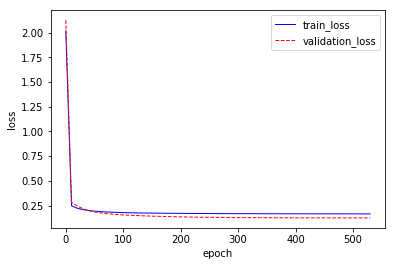

In [11]:
from matplotlib import pyplot as plt
l1 = plt.plot(his_epoch,his_tra,color='blue',linewidth=1.0,label='line')
l2 = plt.plot(his_epoch,his_val,color='red',linewidth=1.0,linestyle='--',label='line')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(labels = ['train_loss', 'validation_loss'], loc = 'best')
plt.show()

In [12]:

stop
# make an error since next cell is saving the model

0.0.weight


NameError: name 'stop' is not defined

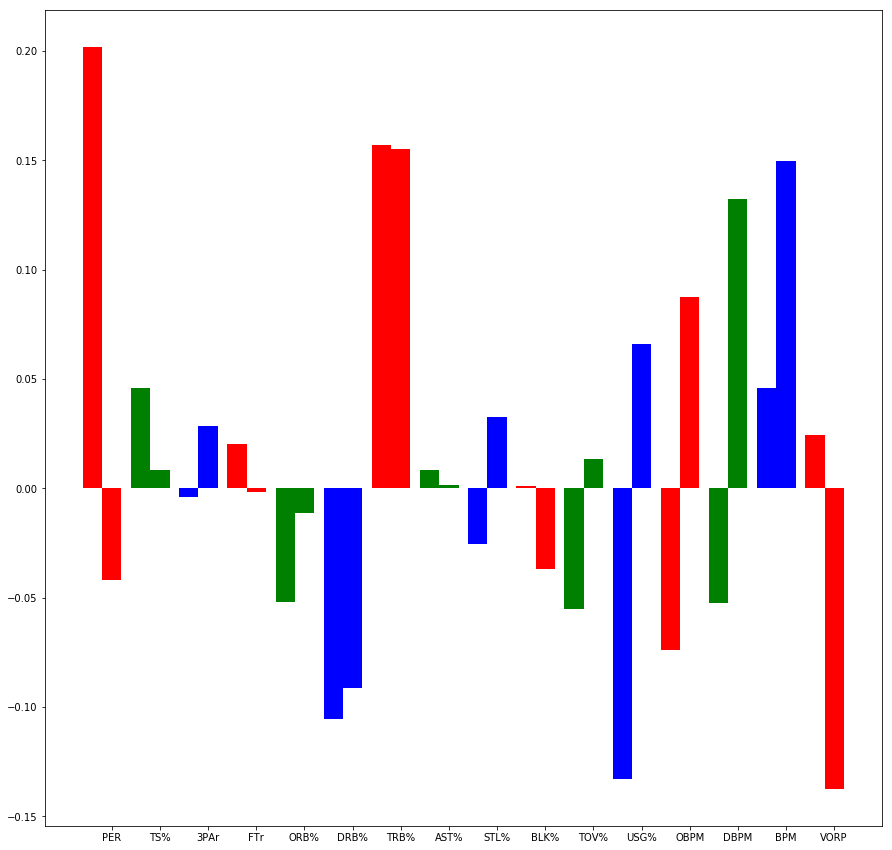

In [38]:
# visualization of the weight
data_name = ['PER','TS%','3PAr','FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%','TOV%','USG%','OBPM','DBPM','BPM','VORP']
from matplotlib import pyplot as plt 
weight = model.state_dict()['0.0.weight'][0]
bar_width = 0.4
x_axis = np.arange(len(data_name))
y_axis_1 = tuple(weight[:16])
y_axis_2 = tuple(weight[16:32])
poly1 = plt.bar(x_axis, y_axis_1,bar_width, color='rgb')  # 如果不指定color，所有的柱体都会是一个颜色
poly2 = plt.bar(x_axis+0.4, y_axis_2, bar_width,color='rgb')
plt.xticks(x_axis+0.4, data_name)
plt.gcf().set_size_inches(15,15)
plt.savefig('trained_model\index_code1_poly2.2.png')

E:\Anaconda\envs\cs231n\lib\site-packages\ipykernel_launcher.py:16: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  app.launch_new_instance()
E:\Anaconda\envs\cs231n\lib\site-packages\ipykernel_launcher.py:18: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
E:\Anaconda\envs\cs231n\lib\site-packages\ipykernel_launcher.py:19: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


tensor(0.1092, grad_fn=<ThAddBackward>)
tensor(0.1737, grad_fn=<ThAddBackward>)
tensor(0.1412, grad_fn=<ThAddBackward>)
tensor(0.0764, grad_fn=<ThAddBackward>)


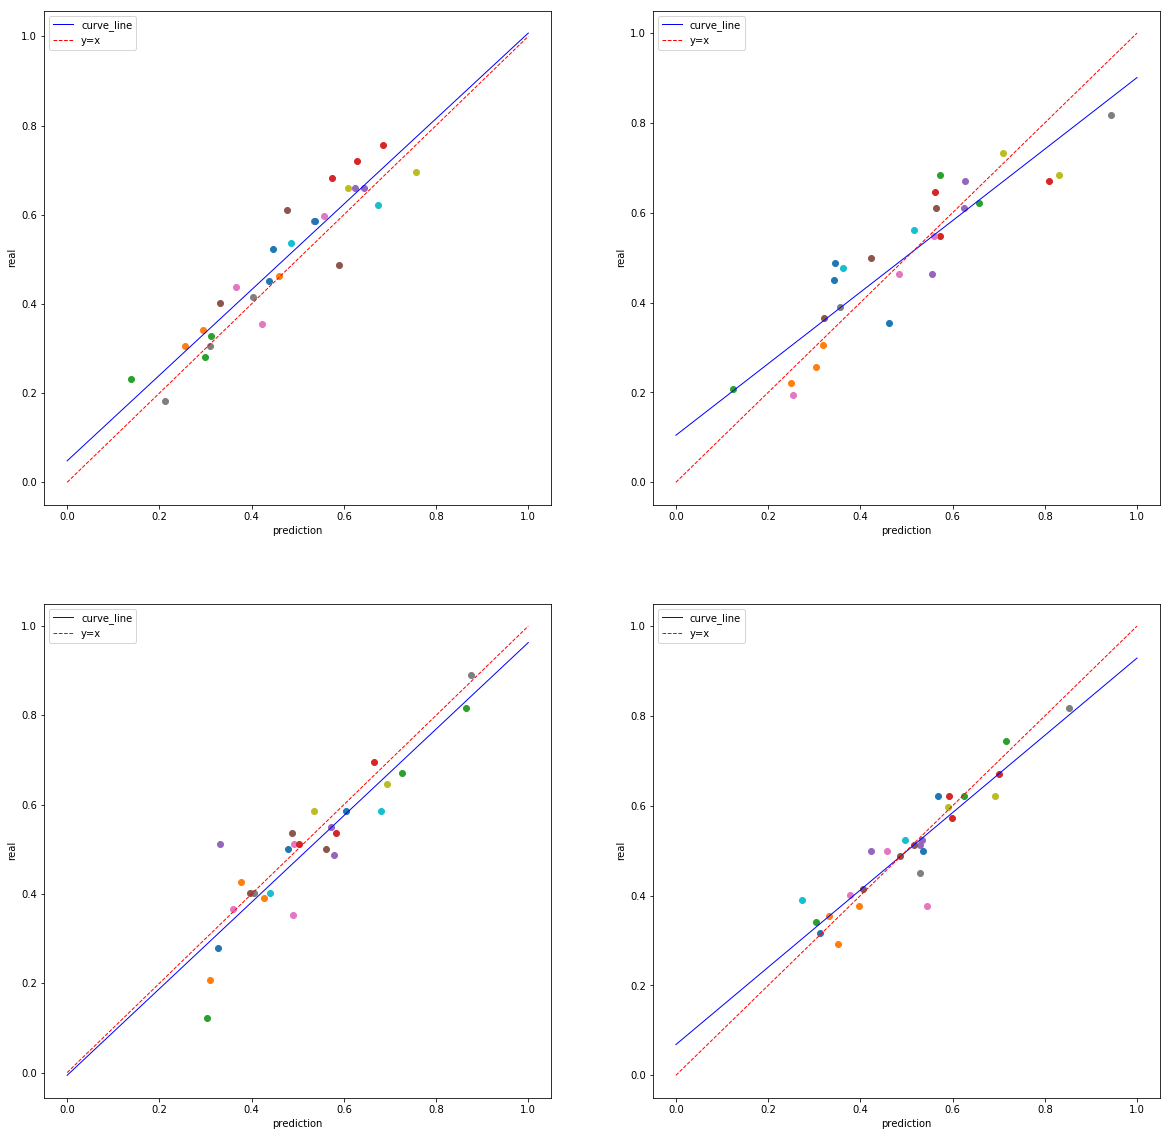

In [40]:

#see the effect on validation set
from matplotlib import pyplot as plt

# change the data_input_test[0] for validation is ok to see performance
for i in range(4):
    x = []
    y = []#test
    loss = 0
    plt.subplot(2,2,i+1)
    for t, content in data_input_validation[i].items():

        PER_C = model(content[0])
                # Loss is the mean square error
        win_rate = sum(PER_C)
        plt.scatter(win_rate[0].data,content[1][0].data)
        x.append(win_rate[0].data)
        y.append(content[1][0].data)
        loss += (win_rate[0]-content[1][0].data)**2
    print(loss)
    z1 = np.polyfit(x, y, 1)
    p1 = np.poly1d(z1)
    x=np.linspace(0,1,100)
    y = z1[0]*x+z1[1]
    
    l1 = plt.plot(x,y,color='blue',linewidth=1.0,label='line')
    x=np.linspace(0,1,100)
    y =x
    l2 = plt.plot(x,y,color='red',linewidth=1.0,linestyle='--',label='line')
    plt.gcf().set_size_inches(20, 20)
    plt.ylabel("real")
    plt.xlabel("prediction")
    plt.legend(labels = ['curve_line', 'y=x'], loc = 'best')
plt.show()

E:\Anaconda\envs\cs231n\lib\site-packages\ipykernel_launcher.py:13: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  del sys.path[0]
E:\Anaconda\envs\cs231n\lib\site-packages\ipykernel_launcher.py:16: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  app.launch_new_instance()
E:\Anaconda\envs\cs231n\lib\site-packages\ipykernel_launcher.py:17: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


tensor(0.1203, grad_fn=<ThAddBackward>)


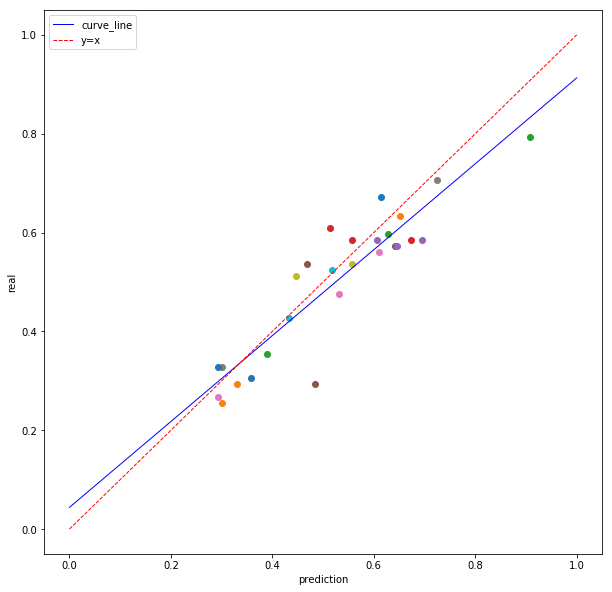

In [41]:
#see the effect on testing set
from matplotlib import pyplot as plt
x = []
y = []#test
loss = 0
pre_dic = {}
# change the data_input_test[0] for validation is ok to see performance
for t, content in data_input_test[0].items():

    PER_C = model(content[0])
            # Loss is the mean square error
    win_rate = sum(PER_C)
    plt.scatter(win_rate[0].data,content[1][0].data)
    #print(win_rate,content[1])
    x.append(win_rate[0].data)
    y.append(content[1][0].data)
    loss += (win_rate[0]-content[1][0].data)**2
    pre_dic[t] = win_rate[0].data
print(loss)
z1 = np.polyfit(x, y, 1)
p1 = np.poly1d(z1)
x=np.linspace(0,1,100)
y = z1[0]*x+z1[1]

l1 = plt.plot(x,y,color='blue',linewidth=1.0,label='line')
x=np.linspace(0,1,100)
y =x
l2 = plt.plot(x,y,color='red',linewidth=1.0,linestyle='--',label='line')
plt.gcf().set_size_inches(10, 10)
plt.ylabel("real")
plt.xlabel("prediction")
plt.legend(labels = ['curve_line', 'y=x'], loc = 'best')

plt.show()

In [33]:
'''
warning!!!!!if you run this cell,make sure you want to overwrite or make a new one.
here are several mothods to save the model.
'''
torch.save(model, 'trained_model\index_code1_poly2.3.fit')
torch.save(model.state_dict(), 'trained_model\index_code1_poly2.3.pkl')

model.state_dict()

OrderedDict([('0.0.weight',
              tensor([[ 0.2016,  0.0460, -0.0041,  0.0204, -0.0521, -0.1056,  0.1569,  0.0085,
                       -0.0253,  0.0008, -0.0554, -0.1330, -0.0738, -0.0524,  0.0459,  0.0245,
                       -0.0418,  0.0085,  0.0284, -0.0019, -0.0111, -0.0913,  0.1551,  0.0014,
                        0.0328, -0.0369,  0.0132,  0.0660,  0.0875,  0.1323,  0.1498, -0.1374]]))])

In [42]:
#load the existing model and compare it with a new trained one
model_compare = torch.load('trained_model\index_code1_poly2.2.fit')
model_compare.state_dict()

OrderedDict([('0.0.weight',
              tensor([[ 0.2331,  0.0535, -0.0071,  0.0219, -0.0711, -0.1629,  0.2112,  0.0138,
                       -0.0278,  0.0070, -0.0656, -0.1519, -0.0515, -0.0335, -0.0185,  0.0774,
                       -0.0806, -0.0046,  0.0327, -0.0025,  0.0066, -0.0292,  0.0910, -0.0068,
                        0.0370, -0.0357,  0.0239,  0.0836,  0.0815,  0.1201,  0.1651, -0.1435]]))])

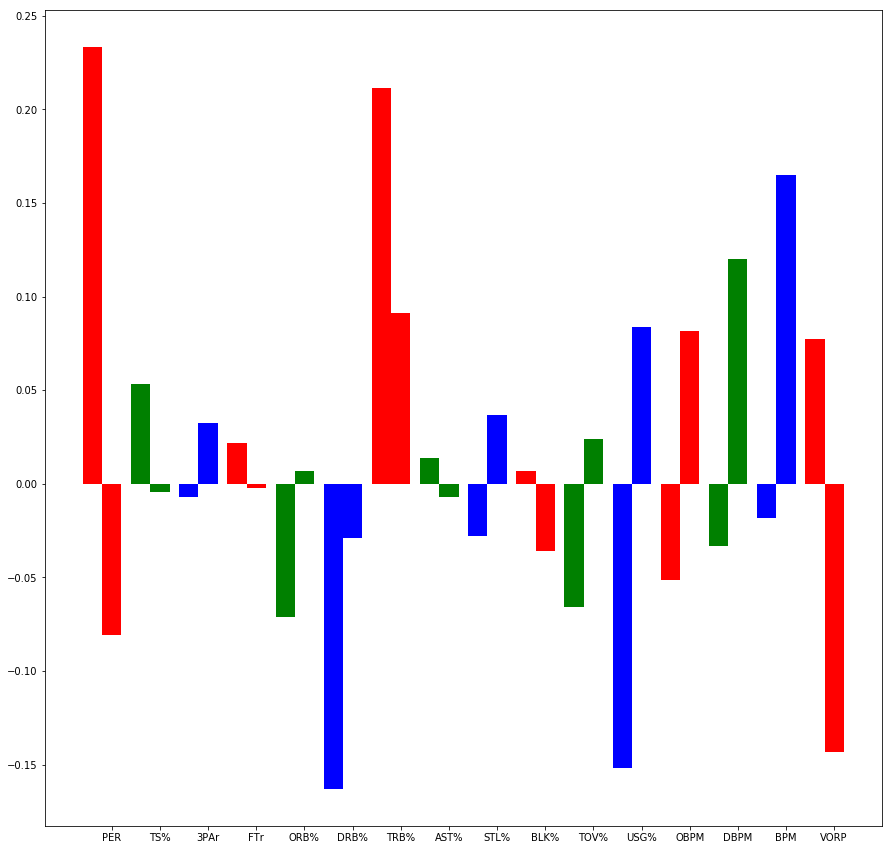

In [43]:
weight = model_compare.state_dict()['0.0.weight'][0]
bar_width = 0.4
x_axis = np.arange(len(data_name))
y_axis_1 = tuple(weight[:16])
y_axis_2 = tuple(weight[16:32])
poly1 = plt.bar(x_axis, y_axis_1,bar_width, color='rgb')  # 如果不指定color，所有的柱体都会是一个颜色
poly2 = plt.bar(x_axis+0.4, y_axis_2, bar_width,color='rgb')
plt.xticks(x_axis+0.4, data_name)
plt.gcf().set_size_inches(15,15)
plt.savefig('trained_model\index_code1_poly2.2.png')

In [ ]:
#see the effect on validation set
from matplotlib import pyplot as plt

# change the data_input_test[0] for validation is ok to see performance
for i in range(4):
    x = []
    y = []#test
    loss = 0
    plt.subplot(2,2,i+1)
    for t, content in data_input_validation[i].items():

        PER_C = model_compare(content[0])
                # Loss is the mean square error
        win_rate = sum(PER_C)
        plt.scatter(win_rate[0].data,content[1][0].data)
        x.append(win_rate[0].data)
        y.append(content[1][0].data)
        loss += (win_rate[0]-content[1][0].data)**2
    print(loss)
    z1 = np.polyfit(x, y, 1)
    p1 = np.poly1d(z1)
    x=np.linspace(0,1,100)
    y = z1[0]*x+z1[1]
    
    l1 = plt.plot(x,y,color='blue',linewidth=1.0,label='line')
    x=np.linspace(0,1,100)
    y =x
    l2 = plt.plot(x,y,color='red',linewidth=1.0,linestyle='--',label='line')
    plt.gcf().set_size_inches(20, 20)
    plt.ylabel("real")
    plt.xlabel("prediction")
    plt.legend(labels = ['curve_line', 'y=x'], loc = 'best')
plt.show()

E:\Anaconda\envs\cs231n\lib\site-packages\ipykernel_launcher.py:13: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  del sys.path[0]
E:\Anaconda\envs\cs231n\lib\site-packages\ipykernel_launcher.py:16: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  app.launch_new_instance()
E:\Anaconda\envs\cs231n\lib\site-packages\ipykernel_launcher.py:17: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


tensor(0.1039, grad_fn=<ThAddBackward>)


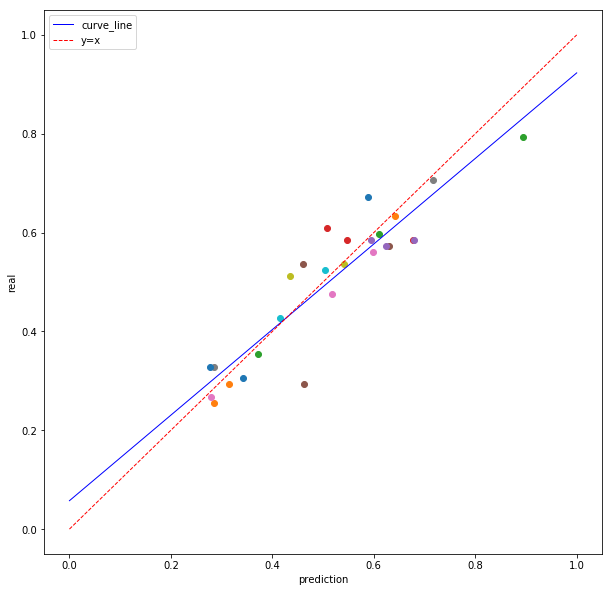

In [46]:
#see the effect on testing set
from matplotlib import pyplot as plt
x = []
y = []#test
loss = 0
pre_dic_compare = {}
# change the data_input_test[0] for validation is ok to see performance
for t, content in data_input_test[0].items():

    PER_C = model_compare(content[0])
            # Loss is the mean square error
    win_rate = sum(PER_C)
    plt.scatter(win_rate[0].data,content[1][0].data)
    #print(win_rate,content[1])
    x.append(win_rate[0].data)
    y.append(content[1][0].data)
    loss += (win_rate[0]-content[1][0].data)**2
    pre_dic_compare[t] = win_rate[0].data
print(loss)
z1 = np.polyfit(x, y, 1)
p1 = np.poly1d(z1)
x=np.linspace(0,1,100)
y = z1[0]*x+z1[1]

l1 = plt.plot(x,y,color='blue',linewidth=1.0,label='line')
x=np.linspace(0,1,100)
y =x
l2 = plt.plot(x,y,color='red',linewidth=1.0,linestyle='--',label='line')
plt.gcf().set_size_inches(10, 10)
plt.ylabel("real")
plt.xlabel("prediction")
plt.legend(labels = ['curve_line', 'y=x'], loc = 'best')

plt.show()

In [47]:
print(pre_dic_compare)

{'BOS2018': tensor(0.5890), 'PHI2018': tensor(0.6423), 'NYK2018': tensor(0.3717), 'CLE2018': tensor(0.5077), 'IND2018': tensor(0.5949), 'MIL2018': tensor(0.4613), 'DET2018': tensor(0.5169), 'CHI2018': tensor(0.2854), 'MIA2018': tensor(0.5419), 'WAS2018': tensor(0.5039), 'ORL2018': tensor(0.3416), 'ATL2018': tensor(0.3153), 'POR2018': tensor(0.6107), 'OKC2018': tensor(0.6765), 'UTA2018': tensor(0.6801), 'MIN2018': tensor(0.6306), 'DEN2018': tensor(0.5976), 'GSW2018': tensor(0.7160), 'LAC2018': tensor(0.4349), 'LAL2018': tensor(0.4150), 'SAC2018': tensor(0.2781), 'PHO2018': tensor(0.2857), 'HOU2018': tensor(0.8938), 'NOP2018': tensor(0.5478), 'SAS2018': tensor(0.6235), 'DAL2018': tensor(0.4620), 'MEM2018': tensor(0.2784)}
